# MAML

- few shot omniglot
- no meta baseline
- maml pytroch
- maml higher

In [77]:
import dill
import copy
import tempfile
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import OrderedDict, defaultdict

from torchmeta.datasets.helpers import omniglot
from torchmeta.utils.data import BatchMetaDataLoader

ds_path = "/data/datasets"

# 1. Omniglot and few-shot learning
- A K-shot N-class classification task contains K labelled examples for each of N classes
- Each task is split into a support and query set. The learner is trained on the support set (inner-loop) and evaluated on the query set, which yields the loss for the meta-learner (outer-loop)
- The dataset is split into a meta-train/background and meta-test/eval set. Each set is a collection of k-shot n-class tasks. Note that this is not the split usually used in the literature.
- Omniglot contains 20 instances of 1623 characters (=32460) from 50 different alphabets
- Omniglot from torchvision comes as a standard dataset, with only a train/val split of characters
- We need the dataset to be in a few shot format by having tasks: sample N classes and build their support (N\*K samples) and query set (N \* (20 - K) samples). Will use pytorch-meta for this.

## 1.1 Raw Omniglot
- Has a train/val split of 964/659 characters

In [2]:
from torchvision.datasets import Omniglot

ds_train = Omniglot(ds_path, background=True)
ds_val = Omniglot(ds_path, background=False)

print(f"train: {len(ds_train)} samples, {len(ds_train) // 20} unqiue characters")
print(f"val: {len(ds_val)} samples,  {len(ds_val) // 20} unqiue characters")

train: 19280 samples, 964 unqiue characters
val: 13180 samples,  659 unqiue characters


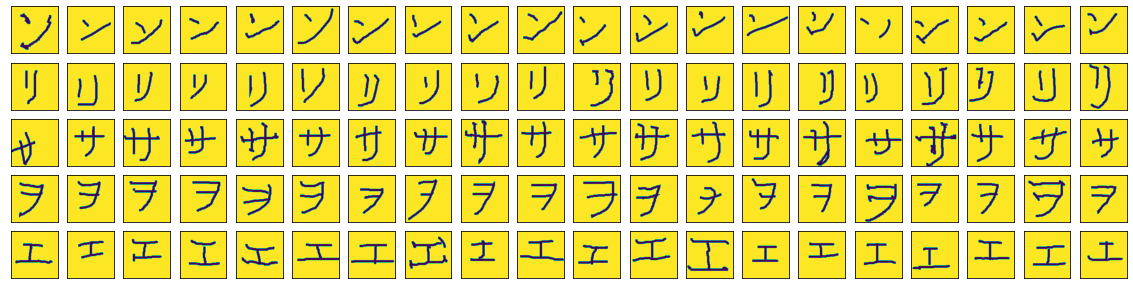

In [3]:
characters = 5
fig, axarr = plt.subplots(characters, 20, figsize=(20, 5))

for ix, ax in enumerate(chain(*axarr)):
    ax.imshow(ds_train[ix][0])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

## 1.2 Torchmeta few-shot dataset
- Provides (among other things) handy dataset and loader classes for few-shot learning
- Splits and augmentations (90 degree rotations) are ones used in literature
- Structured as a meta-dataset class that returns task-dataset objects. The task datasets are randomly generated as combinations of the base characters.
- The base meta train/val/test splits are: 1028/172/423 (=1623)
- However the number of classes is augmented 4x as each character rotation is seen as a new class. This yields following class splits: 4112/688/1692
- The training set can therefore have a really high number of tasks given the 4112 base classes and the chosen N-way classification.

nr train classes: 4112


/home/xapharius/work/libs/miniconda3/envs/dev/lib/python3.8/site-packages/torchvision/transforms/functional.py:973: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


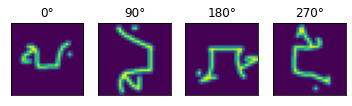

In [4]:
# Total number of classes is 1028 * 4, each rotation is a new class

dataset = omniglot(ds_path, ways=1, shots=10, meta_train=True)
print("nr train classes:", len(dataset))


fig, axarr = plt.subplots(1, 4)
for i in range(4):
    ix = i * len(dataset)//4
    axarr[i].imshow(dataset[ix,]["train"][0][0].permute(1, 2, 0))
    axarr[i].axes.xaxis.set_visible(False)
    axarr[i].axes.yaxis.set_visible(False)
    axarr[i].set_title(f"{i * 90}°")

In [5]:
# Nr of tasks is sum of combinations
from math import comb

ways = 5
dataset = omniglot(ds_path, ways=ways, shots=10, meta_train=True)
len(dataset) == comb(4112, ways)

True

### 1.2.1 Few-shot sample task

/home/xapharius/work/libs/miniconda3/envs/dev/lib/python3.8/site-packages/torchvision/transforms/functional.py:973: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


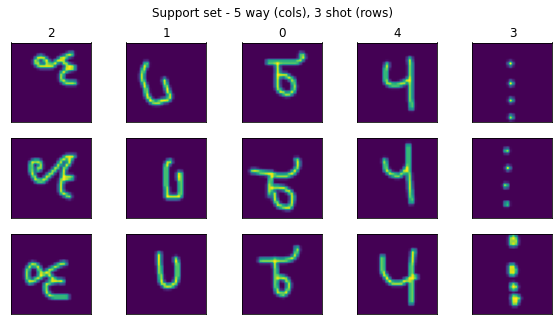

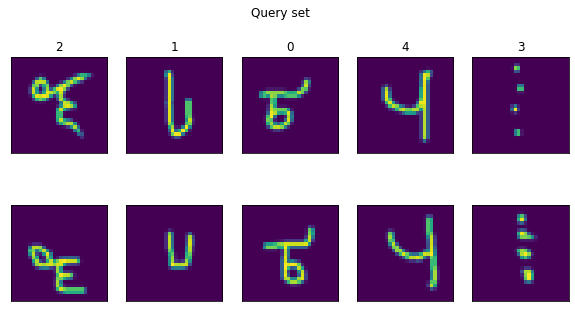

In [6]:
dataset = omniglot(ds_path, ways=5, shots=3, test_shots=2, meta_train=True, download=True)
dataloader = BatchMetaDataLoader(dataset, batch_size=1, num_workers=1)
task_nr = 0

for batch in dataloader:
    train_inputs, train_targets = batch["train"]
    
    fig, axarr = plt.subplots(3, 5, figsize=(10, 5))
    fig.suptitle("Support set - 5 way (cols), 3 shot (rows)")
    for ix, (ax, x, y) in enumerate(zip(chain(*axarr.T), train_inputs[task_nr], train_targets[task_nr])):
            ax.imshow(x.permute(1, 2, 0))
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            if ix % 3 == 0:
                ax.set_title(y.item())
      
    test_inputs, test_targets = batch["test"]
    fig, axarr = plt.subplots(2, 5, figsize=(10, 5))
    fig.suptitle("Query set")
    for ix, (ax, x, y) in enumerate(zip(chain(*axarr.T), test_inputs[task_nr], test_targets[task_nr])):
            ax.imshow(x.permute(1, 2, 0))
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            if ix % 2 == 0:
                ax.set_title(y.item())
       
    break

# 2. Model
- From the MAML paper: "Our model follows the same architecture as the embedding function used by Vinyals et al. (2016), which has 4 modules with a 3 × 3 convolutions and 64 filters, followed by batch normalization (Ioffe & Szegedy, 2015), a ReLU non- linearity, and 2 × 2 max-pooling. The Omniglot images are downsampled to 28 × 28, so the dimensionality of the last hidden layer is 64. As in the baseline classifier used by Vinyals et al. (2016), the last layer is fed into a softmax. For Omniglot, we used strided convolutions instead of max-pooling."

- From the Vinyals' Matching networks paper: "We used a simple yet powerful CNN as the embedding function – consisting of a stack of modules,
each of which is a 3 × 3 convolution with 64 filters followed by batch normalization [10], a Relu
non-linearity and 2 × 2 max-pooling. We resized all the images to 28 × 28 so that, when we stack 4
modules, the resulting feature map is 1 × 1 × 64, resulting in our embedding function f(x). A fully
connected layer followed by a softmax non-linearity is used to define the Baseline Classifier."
- Note: when replacing the maxpool with stride then the dimension is the last layer is not 64 but 256 (the last layer produces 2x2 images). 
- I will be using the maxpool version as it seems to be most common

In [7]:
def get_model(n_classes=5, maxpool=True):
    """
    4 x [64 x 3x3]
    """
    layers = []
    for block in range(4):
        channels_in = 1 if block == 0 else 64
        layers += [
            (f"conv{block}", nn.Conv2d(channels_in, 64, kernel_size=3, bias=False, stride=1 if maxpool else 2, padding=1)),
            (f"bn{block}", nn.BatchNorm2d(64)),
            (f"relu{block}", nn.ReLU()),
        ]
        if maxpool:
            layers += [(f"maxpool{block}", nn.MaxPool2d(2)),]
    encoder = nn.Sequential(OrderedDict(layers))
    
    encoder.eval()
    repr_size =  encoder(torch.randn(1, 1, 28, 28)).numel()
    encoder.train()
    
    classifier = nn.Sequential(OrderedDict([
        ("flatten", nn.Flatten()), 
        ("fc1", nn.Linear(repr_size, n_classes)),
    ]))
    
    return nn.Sequential(OrderedDict([
        ("encoder", encoder),
        ("classifier", classifier),
    ]))

print("maxpool repr size: ", get_model(5, maxpool=True).classifier.fc1.in_features)
print("stride repr size: ", get_model(5, maxpool=False).classifier.fc1.in_features)

maxpool repr size:  64
stride repr size:  256


/home/xapharius/work/libs/miniconda3/envs/dev/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## 2.1 Benchmark baseline learner
- No meta-learning, just an evalaution of the architecture
- See how a model performs on single (5-5) task, and also when training for multiple steps (the default MAML setup is one step).
- Repeat the experiment 5 times (5 models each on it's on task).
- Using the standard learner setup, SGD with lr of 0.4 and no momentum.
- After 1 gradient step the model doesnt learn anything useful (20% acc is the model outputting a constant)
- After 3 (or so) updates the model does learn something reaching a train and val acc of around 50%.
- Interestingly, after 5-ish updates the model forgets everything, but starts to learn again at around the 30th step (double descend?)
- At step 40-45 the model starts to overfit, the final val acc varies significantly between 70% and 100%.

In [44]:
def train_bench_learner(model, X, y, steps=1):
    model.train()
    
    optimiser = optim.SGD(model.parameters(), lr=0.4, momentum=0)
    
    for _ in range(steps):
        out = model(X)
        loss = F.cross_entropy(out, y)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    return model


def get_accuracy(model, X, y):
    model.eval()
    out = model(X)
    out = out.argmax(dim=-1)
    acc = (out == y).float().mean().detach().cpu().item()
    
    model.train()
    return acc

/home/xapharius/work/libs/miniconda3/envs/dev/lib/python3.8/site-packages/torchvision/transforms/functional.py:973: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


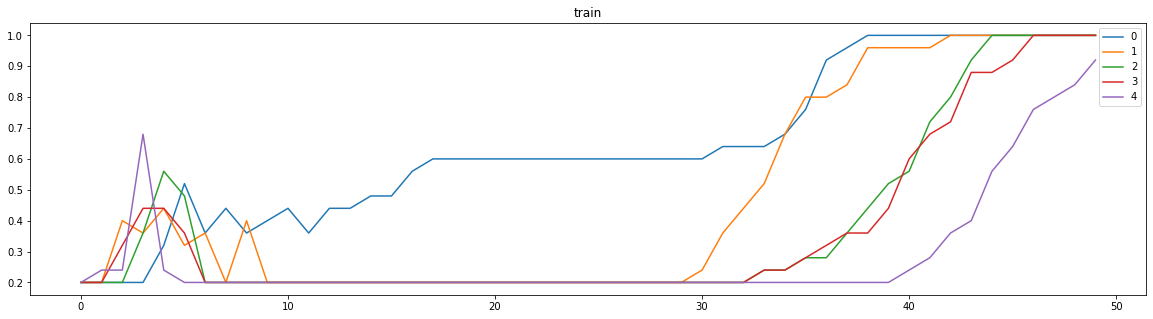

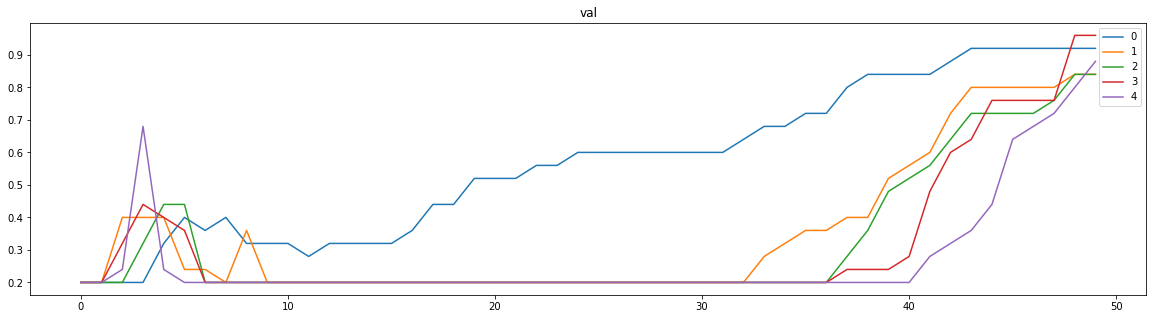

In [9]:
ways = 5; shots = 5

dataset = omniglot(ds_path, ways=ways, shots=shots, meta_train=True)
dataloader = BatchMetaDataLoader(dataset, batch_size=5)
batch = next(iter(dataloader))

train_Xs, train_ys = batch["train"]
val_Xs, val_ys = batch["test"]

train_accs = defaultdict(list)
val_accs = defaultdict(list)
for task_ix, (train_X, train_y, val_X, val_y) in enumerate(zip(train_Xs, train_ys, val_Xs, val_ys)):
    model = get_model(ways)
    
    for step in range(50):
        model = train_bench_learner(model, train_X, train_y)
        acc = get_accuracy(model, train_X, train_y)
        train_accs[task_ix].append(acc)
        
        acc = get_accuracy(model, val_X, val_y)
        val_accs[task_ix].append(acc)

        

for split, accs in [("train", train_accs), ("val", val_accs)]:
    plt.figure(figsize=(20, 5))
    plt.title(split)
    for task_ix, accs_ in accs.items():
        plt.plot(accs_, label=task_ix)
    plt.legend()
    plt.show()

# 3. MAML 
- We start with the meta-learner (outer model)
- The meta learner should be this super versatile, generic model that can be fine-tuned for any fewshot task with a minimum number of updates
- For a new task we create the inner model, which at the starting point is the same as the outer model, but will be adapted to that specific task
    - We differentiate the task loss wrt to the inner model params
- The adapted model's weights are tensors that are the result of a series of operations (w' = F(w, x)): they are not leaf nodes anymore and have grad_fn etc
- We measure the meta-learner's performance by how well the adapted model behaves on the task's validation set
- In order to optimise that measure we regard the inner model's loss as the meta-learning loss
    - We differentiate the inner model's loss on the test val data wrt to the outer model's parameters
    - We can apply the chain rule to factor the inner model;s params since they are a function of the meta-learner
- While it is straight forward to conceptually understand, implementing it is not that simple due to techincal limitations

In [94]:
def train_inner_model(model, X, y, n_iter=1):
    """
    Train manually using simple SGD to make sure the optimisation remains differentiable.
    Note: need to create a new model with the updated params. Can't just replace the params as it would break the computational graph.
    """
    lr = 0.4 # step size
    
    for _ in range(n_iter):
        loss = F.cross_entropy(model(X), y)
        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        new_params = {param_name: param - lr * grad for (param_name, param), grad in zip(dict(model.named_parameters()).items(), grads)}
        model = create_inner_model(model, new_params)
    return model


def eval_meta_learner(model, batch, train_iter=3):
    """Avg support and query acc over tasks in batch"""
    spt_Xs, spt_ys = batch["train"]
    qry_Xs, qry_ys = batch["test"]

    spt_accs, qry_accs = [], []
    for task_ix, (spt_X, spt_y, qry_X, qry_y) in enumerate(zip(spt_Xs, spt_ys, qry_Xs, qry_ys)):
        spt_X, spt_y = spt_X.cuda(), spt_y.cuda()
        qry_X, qry_y = qry_X.cuda(), qry_y.cuda()
        
        inner_model = train_inner_model(model, spt_X, spt_y, n_iter=train_iter)
        spt_accs.append(get_accuracy(inner_model, spt_X, spt_y))
        qry_accs.append(get_accuracy(inner_model, qry_X, qry_y))
    return {"spt_acc": np.mean(spt_accs), "qry_acc": np.mean(qry_accs)}

In [95]:
ways = 5; shots = 1
batch_size = 32
meta_it_n = 500

train_ds = omniglot(ds_path, ways=ways, shots=shots, test_shots=5 * shots, meta_split="train")
train_loader = BatchMetaDataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_ds = omniglot(ds_path, ways=ways, shots=shots, test_shots=5 * shots, meta_split="val")
val_loader = BatchMetaDataLoader(val_ds, batch_size=100, shuffle=True)

outer_model = get_model(n_classes=ways).cuda()
optimiser = torch.optim.Adam(outer_model.parameters(), lr=1e-3)

train_spt_accs, train_qry_accs = [], []
val_spt_accs, val_qry_accs = [], []

meta_it_ix = 0
for batch_ix, batch in enumerate(train_loader):
    spt_Xs, spt_ys = batch["train"]
    qry_Xs, qry_ys = batch["test"]

    batch_train_spt_accs, batch_train_qry_accs = [], []
    for task_ix, (spt_X, spt_y, qry_X, qry_y) in enumerate(zip(spt_Xs, spt_ys, qry_Xs, qry_ys)):
        spt_X, spt_y = spt_X.cuda(), spt_y.cuda()
        qry_X, qry_y = qry_X.cuda(), qry_y.cuda()
        
        inner_model = train_inner_model(outer_model, spt_X, spt_y)
        batch_train_spt_accs.append(get_accuracy(inner_model, spt_X, spt_y))
        batch_train_qry_accs.append(get_accuracy(inner_model, qry_X, qry_y))
        
        outer_loss = F.cross_entropy(inner_model(qry_X), qry_y).backward()    
    optimiser.step()
    optimiser.zero_grad()
    
    train_spt_accs.append(np.mean(batch_train_spt_accs))
    train_qry_accs.append(np.mean(batch_train_qry_accs))
    
    if batch_ix % 10 == 0:
        # evaluating once in a while, and only on one batch to save time
        val_accs = eval_meta_learner(outer_model, next(iter(val_loader)))
        val_spt_accs.append(val_accs["spt_acc"])
        val_qry_accs.append(val_accs["qry_acc"])
        
    meta_it_ix += 1
    if meta_it_ix == meta_it_n:
        break

/home/xapharius/work/libs/miniconda3/envs/dev/lib/python3.8/site-packages/torchvision/transforms/functional.py:973: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


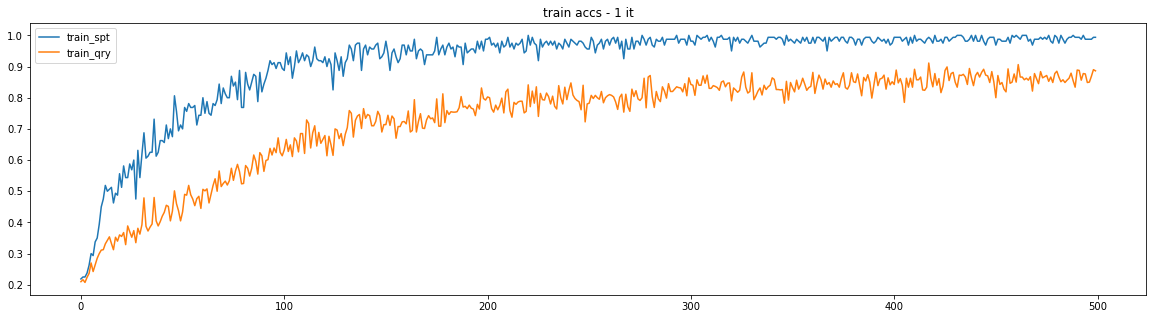

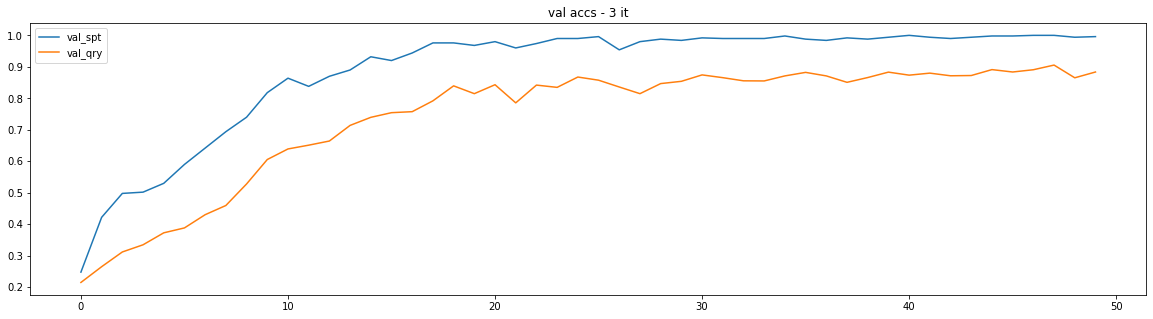

In [99]:
plt.figure(figsize=(20, 5))
plt.title("train accs - 1 it")
plt.plot(train_spt_accs, label="train_spt")
plt.plot(train_qry_accs, label="train_qry")
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.title("val accs - 3 it")
plt.plot(val_spt_accs, label="val_spt")
plt.plot(val_qry_accs, label="val_qry")
plt.legend()
plt.show()

# 4. The Non-Leaf Parameter Problem 
- We have two models (nn.Modules) the outer and the inner. However the parameter of the inner model should allow us to backprop "through" them, since they are tehnically non-leaf variables.
- Ideally there shouldnt be a problem, and we could just call backward on the outer loss to get the gradients for the outer model
- After all, autograd is powerful enough to produce higher order derivatives
- The problem lies on a technical level - in Pytorch a model's weights are interpreted not as raw tensors but as nn.Parameters, which are leaf nodes in the computational graph.
- Wrapping tensors to nn.Parameters, or using state_dict will copy the values and detach them from the computational graph
- These technical challenges are elaborated in the Higher paper. While theoretically a functional and OO implementation should be equivalent, in practice OO makes certain memory optimisations, such as updating variables in place, which prevent having a computational graph history for parameters.
- The problem can be summarised as "non-leaf variables as module parameters" 


Linkes with discussions:
- https://discuss.pytorch.org/t/how-does-one-have-the-parameters-of-a-model-not-be-leafs/70076/6
- https://discuss.pytorch.org/t/non-leaf-variables-as-a-modules-parameters/65775

In [11]:
outer_model = torch.nn.Linear(1, 1, bias=False)

def get_loss(model):
    """Some random mse"""
    x = torch.rand(1, 1)
    y = model(x)
    mse = (y - torch.rand(1))**2
    return mse

## 4.1 Assigning the weight tensor :(
- pytorch complaining weight needs to be parameter not a tensor

In [12]:
outer_model.zero_grad()

inner_loss = get_loss(outer_model)
inner_grads = torch.autograd.grad(inner_loss, outer_model.parameters(), retain_graph=True)[0]
inner_weights = outer_model.weight - inner_grads
inner_model = torch.nn.Linear(1, 1)
inner_model.weight = inner_weights

outer_loss = get_loss(inner_model)
outer_loss.backward()

print(f"Grads for outer model: {outer_model.weight.grad}")

TypeError: cannot assign 'torch.FloatTensor' as parameter 'weight' (torch.nn.Parameter or None expected)

## 4.2 Wrapping as Parameter :(
- Not getting a gradient anymore

In [13]:
outer_model.zero_grad()

inner_loss = get_loss(outer_model)
inner_grads = torch.autograd.grad(inner_loss, outer_model.parameters(), retain_graph=True)[0]
inner_weights = outer_model.weight - inner_grads
inner_model = torch.nn.Linear(1, 1)
inner_model.weight = nn.Parameter(inner_weights)


outer_loss = get_loss(inner_model)
outer_loss.backward()

print(f"Grads for outer model: {outer_model.weight.grad}")

Grads for outer model: None


## 4.3 Tensor Hack :)
- Based on https://discuss.pytorch.org/t/how-does-one-have-the-parameters-of-a-model-not-be-leafs/70076/6
- mr alband suggests del the weight parameter, then assigning the non-leaf tensor
- I would say this is more of a hack as it violates the intended use of model parameters, however if it works it works
- One would need an automated way of monkey patching a whole network this way

In [14]:
outer_model.zero_grad()

inner_loss = get_loss(outer_model)
inner_grads = torch.autograd.grad(inner_loss, outer_model.parameters(), retain_graph=True)[0]
inner_weights = outer_model.weight - inner_grads
inner_model = torch.nn.Linear(1, 1)

del inner_model.weight
inner_model.weight = inner_weights

outer_loss = get_loss(inner_model)
outer_loss.backward()

print(f"Grads for outer model: {outer_model.weight.grad}")

Grads for outer model: tensor([[1.2699]])


## 4.3 Using Functional :)
- The non-leaf variable problem arises only when using the OO implementation of pytorch models
- The functional api doesnt have that problem, however handling models as a nn.Modules is a lot more convenient than a functinal implementation
- It can become quite annoying to use this approach manually which boils down to either having two implementations of a model or wrap certain modules
- However this seems to be the most legitimate solution and used by meta-learning libs 
- The key point is that one has to do this somehow under the hood, in a systematic way
- in order to not interfere with the user experience and be completely transparent the solution has to provide a stateful, OO-like api, which under the hood actually uses the functional api 
- Higher monkey-patches modules at runtime such that their operations are converted to functional blocks, while torchmeta reimplements basic layers to explicity call their functional counterparts

In [15]:
outer_model.zero_grad()

inner_loss = get_loss(outer_model)
inner_grads = torch.autograd.grad(inner_loss, outer_model.parameters(), retain_graph=True)[0]
inner_weights = outer_model.weight - inner_grads
inner_model = lambda x: torch.nn.functional.linear(x, weight=inner_weights)

outer_loss = get_loss(inner_model)
outer_loss.backward()

print(f"Grads for outer model: {outer_model.weight.grad}")

Grads for outer model: tensor([[-0.4457]])


# 5. Pytorch
- am going to use the tensor hack approach and monkey patch the model's params
- very crude and simple approach

In [93]:
def assign_differentiable_param(module, param_name: str, param: torch.Tensor):
    """
    Based on https://discuss.pytorch.org/t/how-does-one-have-the-parameters-of-a-model-not-be-leafs/70076/6
    Deletes the parameter and replaces it with a raw tensor.
    """
    if "." in param_name:
        sub_module = getattr(module, param_name.split(".")[0])
        suffix = ".".join(param_name.split(".")[1:])
        return assign_differentiable_param(sub_module, suffix, param)
    delattr(module, param_name)
    setattr(module, param_name, param)
    

def get_param(module, param_name: str):
    if "." in param_name:
        sub_module = getattr(module, param_name.split(".")[0])
        suffix = ".".join(param_name.split(".")[1:])
        return get_param(sub_module, suffix)
    return getattr(module, param_name)


def create_inner_model(base_model, params: dict = None):
    """
    Creata a model with differentiable parameters from a base model.
    If params is not None, assign those parameters, otherwise make old ones differentiable.
    """
    try:
        inner_model = copy.deepcopy(base_model)
    except RuntimeError:
        # Can't copy a non-leaf parameter model
        # https://stackoverflow.com/questions/56590886/how-to-solve-the-run-time-error-only-tensors-created-explicitly-by-the-user-gr
        with tempfile.NamedTemporaryFile() as tmp:
            # Need dill because of the lambdas
            torch.save(base_model, tmp.name, pickle_module=dill)
            inner_model = torch.load(tmp.name, pickle_module=dill)
    
    if params is None:
        params = {param_name: param + 0 for param_name, param in base_model.named_parameters()}
    
    for param_name, param in params.items():
        assign_differentiable_param(inner_model, param_name, param)
    
    #     Note: by using this hacky monkey patching the new model doesnt have parametes anymore, only tensors. 
    #     This means the get_parameters() won't return anything. We need to patch that, further going down the rabbit hole.
    inner_model.parameter_names = list(params.keys())
    inner_model.named_parameters = lambda: {name: get_param(inner_model, name) for name in inner_model.parameter_names}
    inner_model.parameters = lambda: [get_param(inner_model, name) for name in inner_model.parameter_names]
    return inner_model

In [20]:
inner_model = create_inner_model(outer_model)

In [22]:
next(iter(outer_model.named_parameters()))

('weight',
 Parameter containing:
 tensor([[-0.6797]], requires_grad=True))

## 5.1 Test Implementation
- Just try to backprop through the loss from the inner_model
- See if outer_model has gradients
- When using .backward pytorch shouldnt allow me to access the gradients from the inner_model as they are not leaf nodes. Should see a warning.

In [23]:
outer_model = get_model()
outer_model.encoder.conv0.weight.is_leaf

True

In [25]:
inner_model = create_inner_model(outer_model)
inner_model.encoder.conv0.weight.is_leaf

False

In [26]:
X, y = next(iter(dataloader))["train"]
inner_loss = F.cross_entropy(inner_model(X[0]), y[0])
inner_loss.backward()

In [27]:
inner_model.encoder.conv0.weight.grad

/tmp/ipykernel_7485/2793818363.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  inner_model.encoder.conv0.weight.grad


In [28]:
outer_model.encoder.conv0.weight.grad is not None

True

## 5.2 Meta-training

# 6. Higher

# 7. TorchMeta